In [1]:
import pickle
ensembles = []

for i in range(0,1):
    ensembles.append(pickle.load(open(f'../{i}_rollout_from_diff_ensemble_with_t_and_prev.pkl', 'rb')))


In [18]:
ensembles[0]['state_surface']

24

In [2]:
from ipsl_dcpp.model.ipsl_dataset import IPSL_DCPP
import torch
import lightning as pl
from ipsl_dcpp.model.pangu import PanguWeather
from hydra import compose, initialize
from omegaconf import OmegaConf

import hydra
import os
os.environ['SLURM_NTASKS_PER_NODE'] = '1'
#torch.set_default_dtype(torch.float32)
# os.environ["CUDA_VISIBLE_DEVICES"]=""
#torch.set_default_tensor_type(torch.FloatTensor)

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
pl.seed_everything(cfg.experiment.seed)
train = hydra.utils.instantiate(
    cfg.experiment.train_dataset,
    generate_statistics=False,
    surface_variables=cfg.experiment.surface_variables,
    depth_variables=cfg.experiment.depth_variables,
    plev_variables=cfg.experiment.plev_variables,
    work_path=cfg.environment.work_path,
    scratch_path=cfg.environment.scratch_path,
)
train_dataloader = torch.utils.data.DataLoader(
    train,
    batch_size=1,
    shuffle=False,
    num_workers=1
)

val = hydra.utils.instantiate(
    cfg.experiment.val_dataset,
    generate_statistics=False,
    surface_variables=cfg.experiment.surface_variables,
    depth_variables=cfg.experiment.depth_variables,
    plev_variables=cfg.experiment.plev_variables,
    work_path=cfg.environment.work_path,
    scratch_path=cfg.environment.scratch_path,
)

val_dataloader = torch.utils.data.DataLoader(
    val,
    batch_size=1,
    shuffle=False,
    num_workers=1
)


Seed set to 0
9it [00:01,  4.61it/s]
9it [00:00, 14.49it/s]


In [13]:
batch_timeseries = []
batch_iter = iter(val_dataloader)
val.timestamps
for b in range(118 * 6):
    batch = next(batch_iter)
    batch_timeseries.append(batch)

In [14]:
import numpy as np
batch_timeseries_state = [x['state_surface'] for x in batch_timeseries]
ipsl_ensemble = np.stack(np.array_split(np.stack(batch_timeseries_state),6)[:-1])
ipsl_ensemble[ipsl_ensemble == 0] = 'nan'

In [79]:
batch_timeseries[0]['time']

['2001-02']

In [4]:
import matplotlib.pyplot as plt
for i in ipsl_ensemble:
    plt.plot(np.nanmean(i[:24,0,4],axis=(-1,-2)))

NameError: name 'ipsl_ensemble' is not defined

In [19]:
ipsl_ensemble.shape

(3, 119, 1, 9, 143, 144)

In [18]:
batch_denormed = []
denormed_ensembles = []
denormed_batch_ensembles = []
for i in range(1):
    month_index = 0
    denormalized = []
    batch_denormed = []
    for index in range(118):
   # for index in range(len(ensembles[i]['state_surface'])-2):
        denorm_surface = lambda x,month_index: x*torch.from_numpy(train.surface_stds[month_index]) + torch.from_numpy(train.surface_means[month_index])
        denormalized.append(denorm_surface(ensembles[i]['state_surface'][index],month_index))
        batch_denormed.append(denorm_surface(torch.Tensor(ipsl_ensemble[i][index]),month_index))
        if(month_index == 11):
            month_index = 0
        else:
            month_index += 1
    denormed_ensembles.append(denormalized)
    denormed_batch_ensembles.append(batch_denormed)


# for i in ensemble0['state_surface']:
#     print(i.shape)

In [26]:
denormalized[0].shape

torch.Size([1, 9, 143, 144])

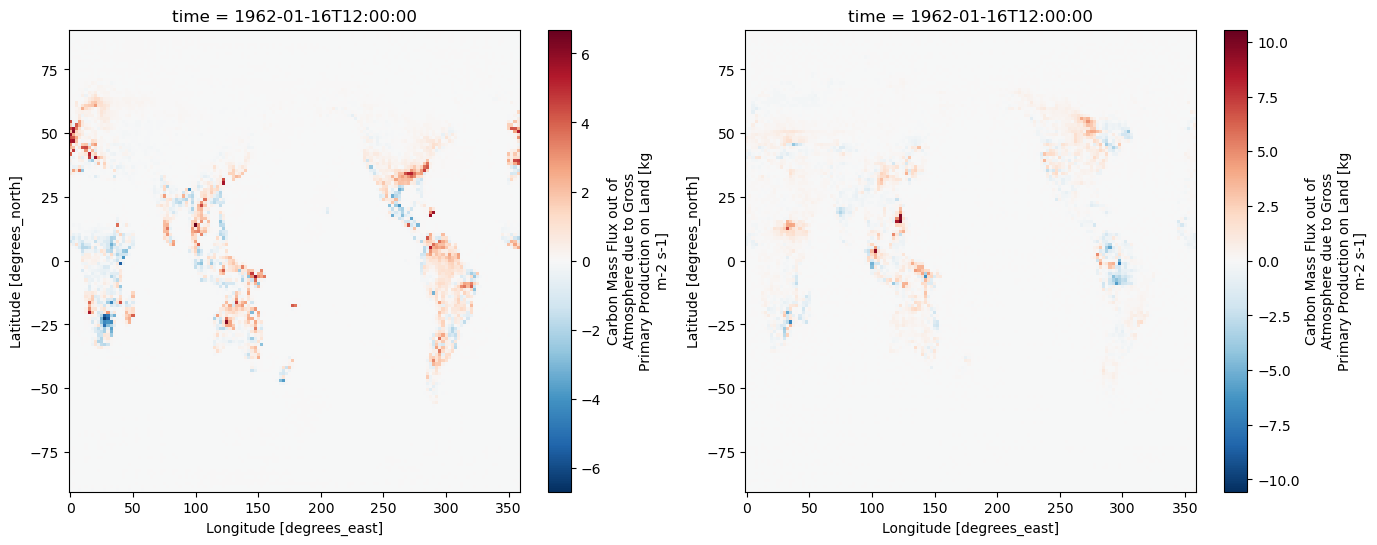

In [4]:
import xarray as xr
import matplotlib.pyplot as plt
#get shell
ds = xr.open_dataset(train.files[0])
shell = ds.isel(time=0)
var_name = 'gpp'
var_index = cfg.experiment.surface_variables.index(var_name)

#plot lat lon map of first rollout
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 6))
#shell[var_name].data = steps[49][0,0,0]
shell[var_name].data = ensembles[0]['state_surface'][0][0][3]
shell[var_name].plot.pcolormesh(ax=ax1)
shell[var_name].data = ensembles[-1]['state_surface'][-1][0][3]
shell[var_name].plot.pcolormesh(ax=ax2)

MovieWriter ffmpeg unavailable; using Pillow instead.


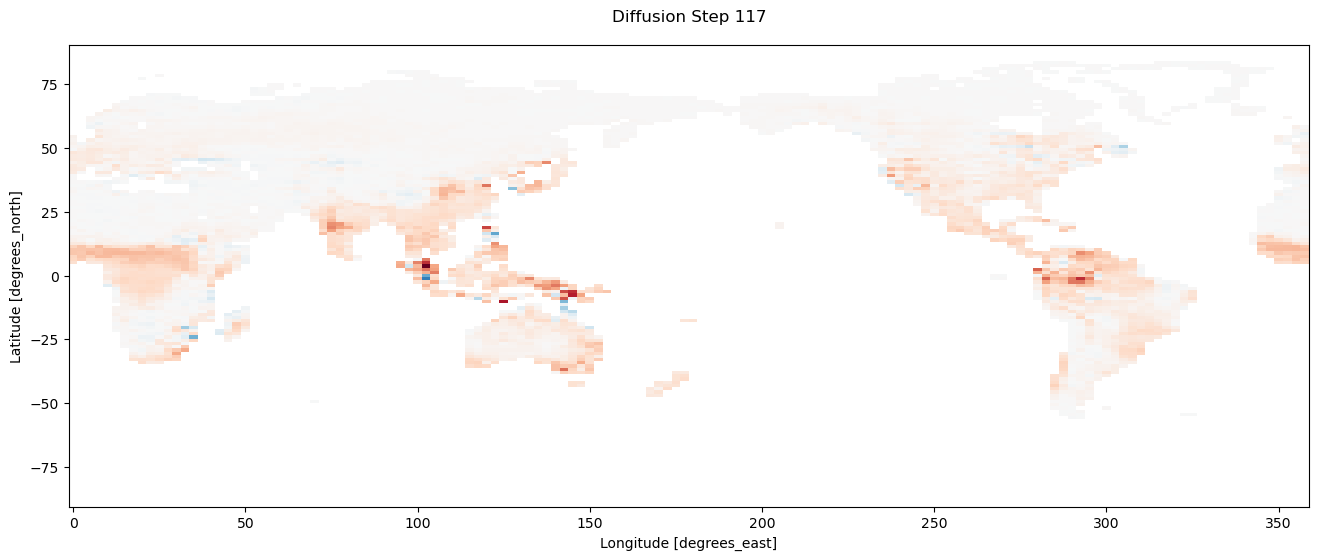

In [28]:
from matplotlib import animation
import matplotlib.pyplot as plt
import numpy as np


fig, ax1 = plt.subplots(1, figsize=(16, 6))
container = []
for time_step in range(118):
    shell['tas'].data = denormalized[time_step][0][1]
    #shell['tas'].data = ensembles[0]['state_surface'][time_step][0][3]
   # line = ax1.pcolormesh(steps[time_step][0,0,0])
    line = shell['tas'].plot.pcolormesh(ax=ax1,add_colorbar=False)
    title = ax1.text(0.5,1.05,"Diffusion Step {}".format(time_step), 
                    size=plt.rcParams["axes.titlesize"],
                    ha="center", transform=ax1.transAxes, )
    container.append([line, title])
plt.title('')

ani = animation.ArtistAnimation(fig, container, interval=100, blit=True)
ani.save("diffusion_npp_deltas.gif")

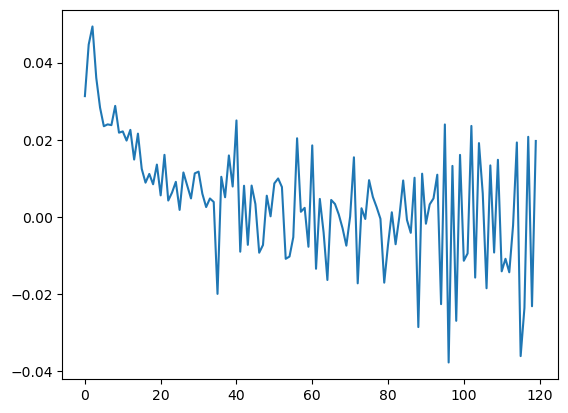

In [9]:
import numpy as np
for i in ensembles:
    plt.plot(np.mean(np.stack(i['state_surface'])[:120,0,3],axis=(-1,-2)))

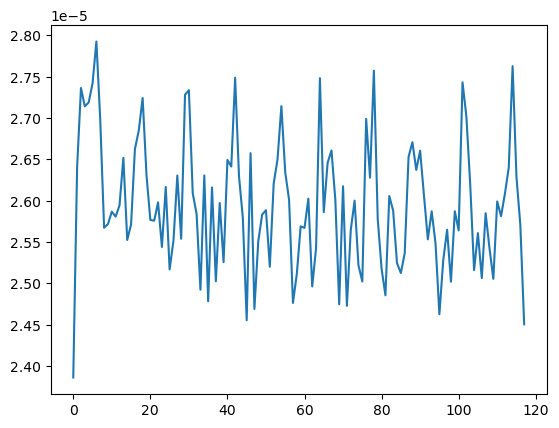

In [19]:
import matplotlib.pyplot as plt
for i in np.stack(denormed_ensembles):
    plt.plot(np.nanmean(np.stack(i)[:,0,-4],axis=(-1,-2)))

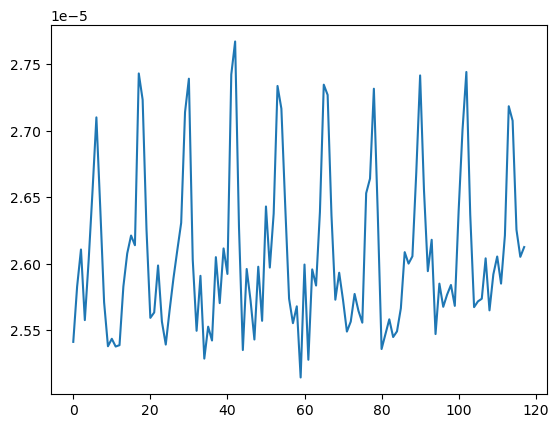

In [20]:
import matplotlib.pyplot as plt
for i in np.stack(denormed_batch_ensembles):
    plt.plot(np.nanmean(np.stack(i)[:,0,-4],axis=(-1,-2)))

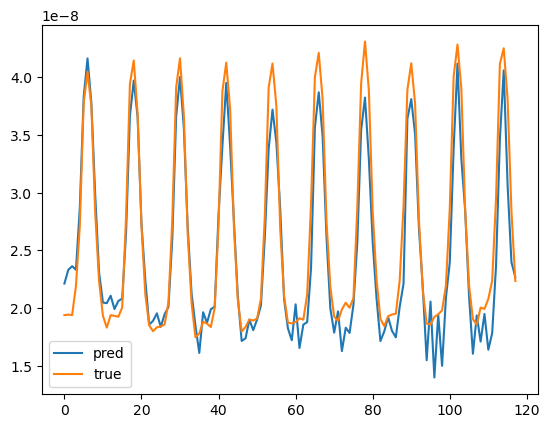

In [21]:
pred = np.stack(denormalized)
plt.plot(np.nanmean(pred[:,0,3],axis=(-1,-2)),label='pred')
plt.plot(np.nanmean(np.stack(batch_denormed)[:,0,3],axis=(-1,-2)),label='true')
plt.legend()

In [25]:
#calculate spread skill score over timeseries 
from ipsl_dcpp.evaluation.metrics import EnsembleMetrics


[tensor([[[[   239.1353,    232.1925,    236.6173,  ...,    240.4438,
               238.1326,    239.5995],
           [   230.9406,    232.7839,    232.9821,  ...,    233.4982,
               237.3191,    231.9190],
           [   236.6243,    241.8298,    238.1510,  ...,    241.2292,
               239.0603,    238.2042],
           ...,
           [   274.8981,    276.5972,    277.1051,  ...,    288.4506,
               287.6650,    289.3629],
           [   277.2664,    273.7841,    273.5733,  ...,    283.1771,
               280.7897,    283.0762],
           [   265.5564,    262.7365,    263.7536,  ...,    273.8939,
               271.6666,    281.4317]],
 
          [[        nan,         nan,         nan,  ...,         nan,
                    nan,         nan],
           [        nan,         nan,         nan,  ...,         nan,
                    nan,         nan],
           [        nan,         nan,         nan,  ...,         nan,
                    nan,         nan],


In [35]:
metrics = EnsembleMetrics(dataset=val_dataloader.dataset)

In [32]:
denormed_batch_ensembles[ensemble_index][time_step].shape

torch.Size([1, 9, 143, 144])

In [36]:
pred = {}
batch = {}
for ensemble_index in range(3):
    for time_step in range(118):

        pred['next_state_surface'] = denormed_ensembles[ensemble_index][time_step]
        batch['next_state_surface'] = denormed_batch_ensembles[ensemble_index][time_step]
        metrics.update(pred,batch)
    break


In [37]:
metrics.compute()

dict_keys(['tas_err', 'tas_var', 'tas_spskr', 'tas_crps', 'gpp_err', 'gpp_var', 'gpp_spskr', 'gpp_crps', 'cVeg_err', 'cVeg_var', 'cVeg_spskr', 'cVeg_crps', 'evspsbl_err', 'evspsbl_var', 'evspsbl_spskr', 'evspsbl_crps', 'ps_err', 'ps_var', 'ps_spskr', 'ps_crps'])


{'tas_err': tensor(1.1797e+08),
 'tas_var': tensor(1.1126e+09),
 'tas_spskr': tensor(3.2373),
 'tas_crps': tensor(-10413.2617),
 'gpp_err': tensor(1.2455e+08),
 'gpp_var': tensor(1.1126e+09),
 'gpp_spskr': tensor(3.1505),
 'gpp_crps': tensor(-10415.2930),
 'cVeg_err': tensor(1.2446e+08),
 'cVeg_var': tensor(1.1126e+09),
 'cVeg_spskr': tensor(3.1517),
 'cVeg_crps': tensor(-10412.8496),
 'evspsbl_err': tensor(1.2455e+08),
 'evspsbl_var': tensor(1.1126e+09),
 'evspsbl_spskr': tensor(3.1505),
 'evspsbl_crps': tensor(-10415.2930),
 'ps_err': tensor(7.9253e+09),
 'ps_var': tensor(1.1126e+09),
 'ps_spskr': tensor(0.3950),
 'ps_crps': tensor(-9620.0791)}